Simulating the transmon readout in the Low-Rank Approximation (LRA).

In [ ]:
using CairoMakie # to plot
using QuantumToolbox # for the physics

# replace this with the path to your local folder
base_path = "/Users/leo/Desktop/PhD_research/code_and_notebooks/low_rank_readout/"

include(joinpath(base_path, "src/low_rank.jl")); # for the low-rank solver
include(joinpath(base_path, "src/transmon.jl")); # for the transmon model and parameters

In [ ]:
# Hilbert space dimensions
Nt = 5
N1 = 4
N2 = 100

M = 20 # rank

tf = 40 # total readout time
t0 = 3. # time offset for the pulse
τ = tf - 2t0 # length of the pulse
σ = 0.5 # sharpness of ramp-up and ramp-down

δt = 0.5 # time step
tlist = 0:δt:tf;

ωd = 45.1158; # dressed frequency of the transmon

In [ ]:
# print the rest of the parameters tucked away in transmon.jl
println(tp)

(Nφ = 300, Ec = 1.9792033717615696, Ej = 100.93937195984005, g = 0.9424777960769379, ωa = 45.23893421169302, ωf = 45.30176606476482, J = 0.18849555921538758, εd = 0.9424777960769379, ωd = 45.1158, κ = 0.18849555921538758, γ = 5.0265482457436686e-5, η = 0.6)


In [4]:
# make the Hamiltonian and initial states
H, c_ops, a, f = get_H_tuples(Nt, N1, N2, tp.Nφ, tp.Ec, tp.Ej, tp.g, tp.ωa, tp.ωf, tp.J, tp.ωd, tp.εd, tp.κ, tp.γ, signal, RWA = false);

ψg = basis(N1, 0) ⊗ basis(N2, 0) ⊗ basis(Nt, 0);
ψe = basis(N1, 0) ⊗ basis(N2, 0) ⊗ basis(Nt, 1);

drive_params = (ωd = ωd, t0 = t0, τ = τ, σ = σ);

In [21]:
# low-rank evolution
@time sol_lr_g = solve_lr(H, ψg, M, tlist, c_ops; e_ops = [f], params = drive_params);
@time sol_lr_e = solve_lr(H, ψe, M, tlist, c_ops; e_ops = [f], params = drive_params);

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 31s (ETA: 0h 00m 00s)
 31.076446 seconds (774.84 k allocations: 12.883 GiB, 1.73% gc time)
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 33s (ETA: 0h 00m 00s)
 33.755198 seconds (847.31 k allocations: 14.102 GiB, 1.45% gc time)


In [ ]:
# full master equation evolution
# @time sol_me_g = mesolve(H, ψg, tlist, c_ops, e_ops = [f], params = drive_params, saveat = tlist)
# @time sol_me_e = mesolve(H, ψe, tlist, c_ops, e_ops = [f], params = drive_params, saveat = tlist)

# the results are also included in the .jld file below
# for the full and RWA simulations, to avoid re-running the long mesolve
using JLD
mesolve_data = load(joinpath(base_path, "data/transmon_mesolve_amplitudes.jld")) 

Dict{String, Any} with 4 entries:
  "βe_rwa" => ComplexF64[0.0+0.0im, 3.75899e-5+0.000977415im, 0.000222502+0.003…
  "βg"     => ComplexF64[0.0+0.0im, 3.57655e-5+0.000944635im, 0.000295565+0.003…
  "βe"     => ComplexF64[0.0+0.0im, 3.57451e-5+0.000944652im, 0.000295592+0.003…
  "βg_rwa" => ComplexF64[0.0+0.0im, 3.75918e-5+0.000977418im, 0.000222447+0.003…

In [ ]:
# rotating-wave evolution
H_rwa, _, _, _ = get_H_tuples(Nt, N1, N2, tp.Nφ, tp.Ec, tp.Ej, tp.g, tp.ωa, tp.ωf, tp.J, tp.ωd, tp.εd, tp.κ, tp.γ, signal, RWA = true);

# @time sol_me_rwa_g = mesolve(H_rwa, ψg, tlist, c_ops, e_ops = [f], params = drive_params, saveat = tlist)
# @time sol_me_rwa_e = mesolve(H_rwa, ψe, tlist, c_ops, e_ops = [f], params = drive_params, saveat = tlist)

In [9]:
# unpack the results

# low-rank
βg_lr = sol_lr_g.expect[1];
βe_lr = sol_lr_e.expect[1];
ng_lr = abs2.(βg_lr);
ne_lr = abs2.(βe_lr);

# mesolve

# if using the data from the .jld file
βg_me = mesolve_data["βg"];
βe_me = mesolve_data["βe"];
βg_me_rwa = mesolve_data["βg_rwa"];
βe_me_rwa = mesolve_data["βe_rwa"];

# else, if re-running mesolve
# βg_me = sol_me_g.expect[1, :] |> vec;
# βe_me = sol_me_e.expect[1, :] |> vec;
# βg_me_rwa = sol_me_rwa_g.expect[1, :] |> vec;
# βe_me_rwa = sol_me_rwa_e.expect[1, :] |> vec;

ng_me = abs2.(βg_me);
ne_me = abs2.(βe_me);
ng_me_rwa = abs2.(βg_me_rwa);
ne_me_rwa = abs2.(βe_me_rwa);

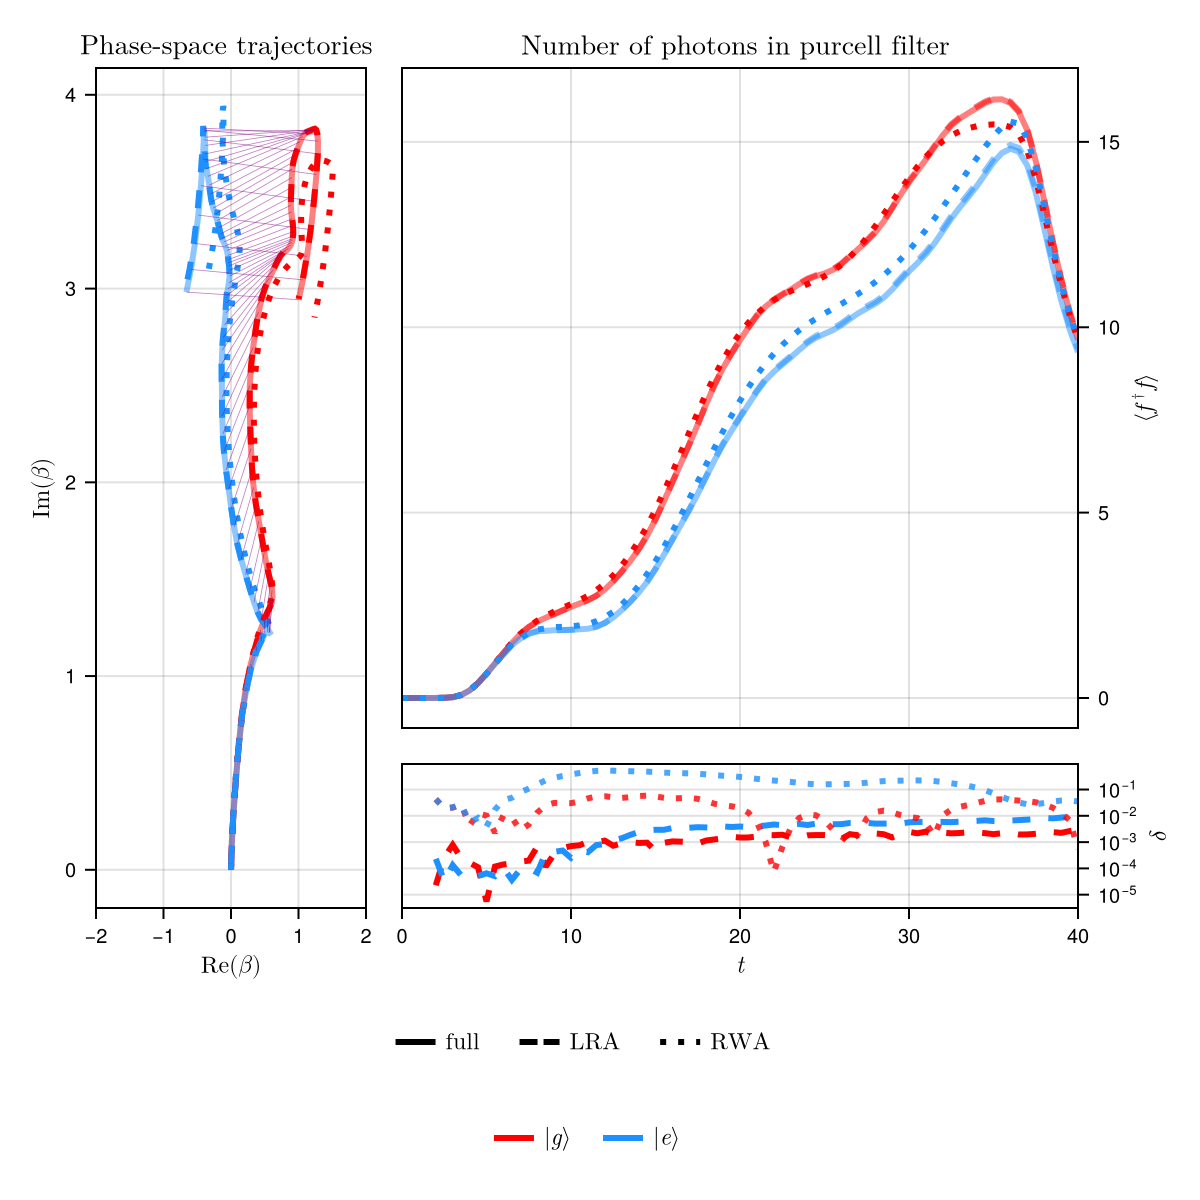

In [20]:
# plot the results

label_size = 12
tick_size = 10

alpha_me = 0.5
alpha_rwa = 0.8
lw = 3

fig = Figure(size = (600, 600))

ax1 = Axis(fig[1:2, 1], title = L"Phase-space trajectories $$", xlabel = L"$\mathrm{Re}(\beta)$", 
ylabel = L"$\mathrm{Im}(\beta)$", xlabelsize = label_size, 
ylabelsize = label_size, yticklabelsize = tick_size, 
xticklabelsize = tick_size)

lines!(ax1, real.(βg_me), imag.(βg_me), color = :red, alpha = alpha_me, label = L"mesolve $$ ", linewidth = lw)
lines!(ax1, real.(βe_me), imag.(βe_me), color = :dodgerblue, alpha = alpha_me, linewidth = lw)

lines!(ax1, real.(βg_lr), imag.(βg_lr), linestyle = :dash, color = :red, alpha = 1, label = L"LRA w/ $M = 20$", linewidth = lw)
lines!(ax1, real.(βe_lr), imag.(βe_lr), linestyle = :dash, color = :dodgerblue, alpha = 1, linewidth = lw)

lines!(ax1, real.(βg_me_rwa), imag.(βg_me_rwa), linestyle = :dot, color = :red, alpha = 1, label = L"mesolve w/ RWA $$", linewidth = lw)
lines!(ax1, real.(βe_me_rwa), imag.(βe_me_rwa), linestyle = :dot, color = :dodgerblue, alpha = 1, linewidth = lw)

for i in 1:length(tlist)
    lines!(ax1, [real.(βg_me)[i], real.(βe_me)[i]], [imag.(βg_me)[i], imag.(βe_me)[i]], color = :purple, linewidth = 0.4, alpha = alpha_me)
end

xlims!(ax1, -2, 2)

ax2 = Axis(fig[1, 2], title = L"Number of photons in purcell filter $$", 
xlabel = L"$t$", ylabel = L"$\langle f^\dagger f \rangle $", 
yaxisposition = :right, xlabelsize = label_size, 
ylabelsize = label_size, yticklabelsize = tick_size, 
xticklabelsize = tick_size)

lines!(ax2, tlist, ng_me, color = :red, label = L"mesolve $|g\rangle $", alpha = 0.5, linewidth = lw)
lines!(ax2, tlist, ne_me, color = :dodgerblue, label = L"mesolve $| e \rangle $", alpha = 0.5, linewidth = lw)

lines!(ax2, tlist, ng_lr, linestyle = :dash, color = :red, label = L"LR $|g\rangle $", alpha = 0.5, linewidth = lw)
lines!(ax2, tlist, ne_lr, linestyle = :dash, color = :dodgerblue, label = L"LR $| e \rangle $", alpha = 0.5, linewidth = lw)

lines!(ax2, tlist, ng_me_rwa, linestyle = :dot, color = :red, label = L"RWA $|g\rangle $", alpha = 1, linewidth = lw)
lines!(ax2, tlist, ne_me_rwa, linestyle = :dot, color = :dodgerblue, label = L"RWA $| e \rangle $", alpha = 1, linewidth = lw)

hidexdecorations!(ax2, ticks = true, grid = false)

ax3 = Axis(fig[2, 2], xlabel=L"$t$", ylabel=L"$\delta$", 
yscale = log10, yaxisposition = :right, xlabelsize = label_size, 
ylabelsize = label_size, yticklabelsize = tick_size, 
xticklabelsize = tick_size)

transient = 5

lines!(ax3, tlist[transient:end], abs.((ng_lr - ng_me) ./ ng_me)[transient:end], linestyle = :dash, color = :red, linewidth=lw, alpha=1, label = L"Residuals $$")
lines!(ax3, tlist[transient:end], abs.((ne_lr - ne_me) ./ ne_me)[transient:end], linestyle = :dash, color = :dodgerblue, linewidth=lw, alpha=1, label = L"Residuals $$")
lines!(ax3, tlist[transient:end], abs.((ng_me_rwa - ng_me) ./ ng_me)[transient:end], linestyle = :dot, color = :red, linewidth=lw, alpha=alpha_rwa, label = L"RWA residuals $$")
lines!(ax3, tlist[transient:end], abs.((ng_me_rwa - ne_me) ./ ne_me)[transient:end], linestyle = :dot, color = :dodgerblue, linewidth=lw, alpha=alpha_rwa, label = L"RWA residuals $$")

xlims!(ax3, 0, tf)
xlims!(ax2, 0, tf)

rowsize!(fig.layout, 1, Relative(5/7))
colsize!(fig.layout, 1, Relative(2/7))

# Legend for linestyles (row 1)
legend_lines_style = [
    LineElement(color = :black, linestyle = :solid, linewidth = 3),  # mesolve
    LineElement(color = :black, linestyle = (:dash, 1), linewidth = 3),   # low-rank
    LineElement(color = :black, linestyle = :dot, linewidth = 3)     # RWA
]
legend_labels_style = [
    L"full $$",
    L"LRA $$",
    L"RWA $$"
]

# Legend for colors (row 2)
legend_lines_color = [
    LineElement(color = :red, linestyle = :solid, linewidth = 3),    # ground
    LineElement(color = :dodgerblue, linestyle = :solid, linewidth = 3) # excited
]
legend_labels_color = [
    L"$|g\rangle $",
    L"$|e\rangle $"
]

# Place both legends above the plot, stacked vertically
Legend(fig[3, 1:2], legend_lines_style, legend_labels_style, orientation = :horizontal, framevisible=false, padding=(5,5,5,5), labelsize=label_size)
Legend(fig[4, 1:2], legend_lines_color, legend_labels_color, orientation = :horizontal, framevisible=false, padding=(5,5,5,5), labelsize=label_size)


fig